In [30]:
# Data:
import pandas as pd
import numpy as np
from scipy.stats import norm, skew
from scipy.special import boxcox1p
import datetime

# Visualize:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

# Modelling:
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor, AdaBoostRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold, cross_val_score
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, Imputer, RobustScaler
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline

# Ipython:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))

import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn

In [2]:
###############
# Import Data #
###############

train_data = pd.read_csv("../train.csv", sep=",")
test_data = pd.read_csv("../test.csv", sep=",")
print ("Shape train: ", train_data.shape)
print ("Shape test: ", test_data.shape)
print("")

# Save "Id" column
train_ID = train_data["Id"]
test_ID = test_data["Id"]

# Drop "Id" column
train_data = train_data.drop("Id", axis = 1)
test_data = test_data.drop("Id", axis = 1)

#print("raw_data: info:")
#print(raw_data.info())
#print("")
#print("raw_data: describe:")
#print(raw_data.describe())
#print("")
#print("Share of nan:")
#print(raw_data.isna().sum() / raw_data.shape[0])
#print("")
print ("Shape train: ", train_data.shape)
print ("Shape test: ", test_data.shape)

train_data.head(5)

Shape train:  (1460, 81)
Shape test:  (1459, 80)

Shape train:  (1460, 80)
Shape test:  (1459, 79)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


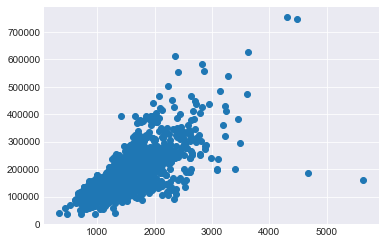

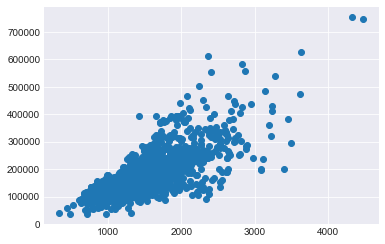

In [3]:
#####################
# Outlier Detection #
#####################

fig, ax = plt.subplots()
ax.scatter(x = train_data['GrLivArea'], y = train_data['SalePrice'])
plt.show()

# Entfernen der Outlier in der Ecke
train_data = train_data.drop(train_data[(train_data['GrLivArea']>4000) & (train_data['SalePrice']<300000)].index)

fig, ax = plt.subplots()
ax.scatter(x = train_data['GrLivArea'], y = train_data['SalePrice'])
plt.show()

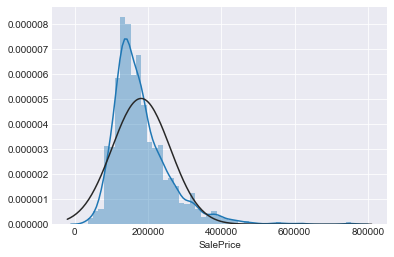

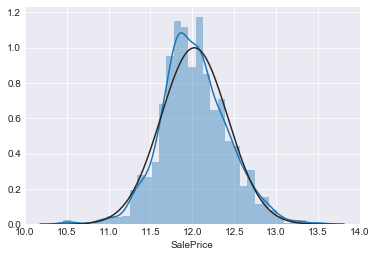

In [4]:
###########################
# Schiefe Target Variable #
###########################

# Target Variable ist rechts-schief:
sns.distplot(train_data["SalePrice"] , fit=norm);
plt.show()

# Log-Transformation der Target-Variable:
train_data["SalePrice"] = np.log1p(train_data["SalePrice"])

# Re-check der neuen Verteilung: 
sns.distplot(train_data["SalePrice"] , fit=norm);
plt.show()

In [5]:
#######################
# Feature Engineering #
#######################

# Zusammenführen von train und test data
n_train = train_data.shape[0]
n_test = test_data.shape[0]
y_train = train_data.SalePrice.values
all_data = pd.concat((train_data, test_data)).reset_index(drop=True)
all_data = all_data.drop(["SalePrice"], axis=1)
print ("Shape all: ", all_data.shape)

train_data.head(5)

Shape all:  (2917, 79)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,12.247699
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,12.109016
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,12.317171
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,11.849405
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,12.429220


In [6]:
################
# Missing Data #
################

# Tabelle für Missing Values:
all_data_na = all_data.isna().sum() / all_data.shape[0] * 100
all_data_na = pd.DataFrame({"Anteil NaN" :all_data_na}).sort_values(by=["Anteil NaN"], ascending=False)
print(all_data_na.head(10))
print("")

# Ersetze kategorische NaNs mit dem String "None"
def nan_replacer_ob (df, liste):
    for i in liste:
        df[i] = df[i].fillna("None")
    return df

replace_list_ob = ["PoolQC", "MiscFeature", "Alley", "Fence", "FireplaceQu", "BsmtQual", "BsmtCond",
                   "BsmtExposure", "BsmtFinType1", "KitchenQual", "BsmtFinType2", "GarageType", "MasVnrType", 
                   "GarageFinish", "GarageQual", "GarageCond"]
all_data = nan_replacer_ob(all_data, replace_list_ob)

# Idee: Lotfrontage ist bei gleicher Nachbarschaft ähnlich, deswegen wird diese hergenommen:
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

# Ersetze numerische NaNs mit der int 0
def nan_replacer_num (df, liste):
    for i in liste:
        df[i] = df[i].fillna(0)
    return df

replace_list_num = ["GarageYrBlt", "GarageArea", "GarageCars", "BsmtFinSF1", "MasVnrArea", 
                    "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF", "BsmtFullBath", "BsmtHalfBath"]
all_data = nan_replacer_num(all_data, replace_list_num)

# Keine Unterschiede der Ausprägungen, löschen:
#all_data = all_data.drop(['Utilities'], axis=1)

# Beschreibung der Daten sagt NaN bedeutet "Typical" ("Typ"):
all_data["Functional"] = all_data["Functional"].fillna("Typ")


# Ersetze wenige fehlende Daten mit Modus
def nan_replacer_mode (df, liste):
    for i in liste:
        df[i] = df[i].fillna(df[i].mode()[0])
    return df

replace_list_mode = ["Electrical", "MSZoning", "SaleType", "Exterior1st", "Exterior2nd"]
all_data = nan_replacer_mode(all_data, replace_list_mode)

# Noch NaNs vorhanden? Nein
all_data_na = all_data.isna().sum() / all_data.shape[0] * 100
print ("Anteil der NaNs im Datensatz nach Cleaning:", all_data_na[1])

              Anteil NaN
PoolQC         99.691464
MiscFeature    96.400411
Alley          93.212204
Fence          80.425094
FireplaceQu    48.680151
LotFrontage    16.660953
GarageYrBlt     5.450806
GarageQual      5.450806
GarageFinish    5.450806
GarageCond      5.450806

Anteil der NaNs im Datensatz nach Cleaning: 0.0


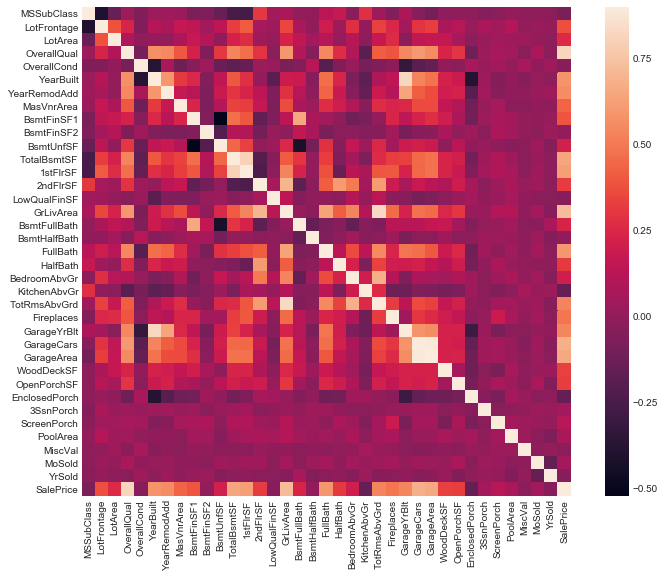

In [7]:
####################
# Data Correlation #
####################

# Correlation um Wichtigkeit gegenüber SalePrice (y) zu sehen
correlation = train_data.corr()#.sort_values(by=["SalePrice"], ascending=False)
plt.subplots(figsize=(12,9))
sns.heatmap(correlation, vmax=0.9, square=True)
plt.show()

# Wenn 2 Features stark korrelieren, wird das entfernt, das weniger mit SalePrice korreliert
all_data = all_data.drop(['GarageArea','1stFlrSF','TotRmsAbvGrd','2ndFlrSF'], axis=1)

In [8]:
####################################
#  Numeric transforming & Skewness #
####################################

# Umwandeln ausgewählter numerischer Variablen in kategorische:
def stringi (df, liste):
    for i in liste:
        df[i] = df[i].astype(str)
    return df

string_list = ["MSSubClass", "OverallCond", "YrSold", "MoSold"]
all_data = stringi(all_data, string_list)
print("Numerics transformed.")
print("")

# Berechnung der Skewness der Numerics
def top_skews(df):
    numerics = list(df.select_dtypes(exclude=["object"]))
    skewed_feats = df[numerics].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
    skewness = pd.DataFrame({'Skew' :skewed_feats})
    return skewness
    
all_data_skews = top_skews(all_data)
print ("Top numeric Skews:")
print (all_data_skews.head(10))
print("")

# Ermittlung der extremsten Sew-Variablen
SKEW_GRENZE = 0.75
all_data_skews = all_data_skews[abs(all_data_skews) > SKEW_GRENZE]
all_data_skews = all_data_skews.dropna(subset=["Skew"])

# BoxCox Transform auf den Extremsten
skewed_features = all_data_skews.index
lam = 0.15
for feat in skewed_features:
    all_data[feat] = boxcox1p(all_data[feat], lam)
print("Skews transformed.")

Numerics transformed.

Top numeric Skews:
                    Skew
MiscVal        21.939672
PoolArea       17.688664
LotArea        13.109495
LowQualFinSF   12.084539
3SsnPorch      11.372080
KitchenAbvGr    4.300550
BsmtFinSF2      4.144503
EnclosedPorch   4.002344
ScreenPorch     3.945101
BsmtHalfBath    3.929996

Skews transformed.


In [9]:
###############################
#  Data Preparation Pipeline  #
###############################

t1 = datetime.datetime.now().replace(microsecond=0)


class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X = X[self.attribute_names]
        X = pd.DataFrame(X)
        return X

# Hier Hyperparameter zum tunen!
class num_imputer_Transformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        imputer = Imputer(strategy="median")
        X = imputer.fit_transform(X)
        X = pd.DataFrame(X)
        print ("imputer_Transformer shape", X.shape)
        print ("Zeit nach imputer_Transformer: ", datetime.datetime.now().replace(microsecond=0)-t1)
        print ("")
        return X

class standardScaler_Transformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
        for i in X.columns:
            if X[i].dtype != "object":
                scaled = X[[i]].fillna("0")
                scaled = scaler.fit_transform(scaled)
                X[[i]] = scaled
        X = pd.DataFrame(X)
        print ("standardScaler_Transformer shape", X.shape)
        print ("Zeit nach standardScaler_Transformer: ", datetime.datetime.now().replace(microsecond=0)-t1)
        print ("")
        return X
    
    
class encoder_Transformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        encoder = LabelEncoder()
        for i in X.columns:
            encoded = X[i].fillna("nix")
            encoded = encoder.fit_transform(encoded)
            X[i] = encoded
        print ("encoder_Transformer shape", X.shape)
        print ("Zeit nach encoder_Transformer: ", datetime.datetime.now().replace(microsecond=0)-t1)
        print ("")
        return X   

# Offen: Unterschied pd.get_dummies und OneHotEncoderrelevant?!
class oneHot_Transformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        onehoter = OneHotEncoder(sparse=False, dtype="int64")
        X = onehoter.fit_transform(X)
        X = pd.DataFrame(X)
        print ("oneHot_Transformer shape", X.shape)
        print ("Zeit nach oneHot_Transformer: ", datetime.datetime.now().replace(microsecond=0)-t1)
        print ("")
        return X
    
    
objects = list(all_data.select_dtypes(include=["object"]))
numerics = list(all_data.select_dtypes(exclude=["object"]))

num_pipeline = Pipeline([
    ("data", DataFrameSelector(numerics)),
    ("impute", num_imputer_Transformer()),
    ("scale", standardScaler_Transformer())
])
ob_pipeline = Pipeline([
    ("data", DataFrameSelector(objects)),
    ("encode", encoder_Transformer()),
    ("one", oneHot_Transformer())
])
combined_features = FeatureUnion([("num", num_pipeline), ("ob", ob_pipeline)])

all_data_prepared = pd.DataFrame(combined_features.fit_transform(all_data))
print ("all_data_prepared shape", all_data_prepared.shape)
print ("Zeit nach X_prepared: ", datetime.datetime.now().replace(microsecond=0)-t1)
print ("")

# Auseinanderziehen der Train und Test Daten:
train_prepared = all_data_prepared[:n_train]
print ("train_prepared shape", train_prepared.shape)
test_prepared = all_data_prepared[n_train:]
print ("test_prepared shape", test_prepared.shape)
print ("")

print ("train_prepared head:")
train_prepared.head(5)

imputer_Transformer shape (2917, 28)
Zeit nach imputer_Transformer:  0:00:01

standardScaler_Transformer shape (2917, 28)
Zeit nach standardScaler_Transformer:  0:00:01

encoder_Transformer shape (2917, 47)
Zeit nach encoder_Transformer:  0:00:01

oneHot_Transformer shape (2917, 309)
Zeit nach oneHot_Transformer:  0:00:01

all_data_prepared shape (2917, 337)
Zeit nach X_prepared:  0:00:01

train_prepared shape (1458, 337)
test_prepared shape (1459, 337)

train_prepared head:


,0,1,2,3,4,5,6,7,8,9,...,327,328,329,330,331,332,333,334,335,336
0,-0.112352,0.169987,0.802160,-0.358159,1.090257,-0.251463,-0.545958,-0.424069,-0.924763,0.783237,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,-0.112352,0.169987,0.976416,-0.358159,-0.818675,3.880090,-0.130784,-0.424069,0.626435,0.783237,...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,-0.112352,0.169987,0.612777,-0.358159,1.090257,-0.251463,0.168358,-0.424069,0.626435,0.783237,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,-0.112352,0.169987,0.236723,-0.358159,1.090257,-0.251463,0.330207,2.903253,0.626435,-1.027145,...,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,-0.112352,1.385311,0.763268,-0.358159,1.090257,-0.251463,0.257580,-0.424069,0.626435,0.783237,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [10]:
###########################################
#  Randomized Grid Search: Random Forest  #
###########################################

t1 = datetime.datetime.now().replace(microsecond=0)

# Random Forest Regressor
forest_reg = RandomForestRegressor()

#Best Params:
#{'n_estimators': 1100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 15}
random_grid = {'n_estimators': [int(x) for x in np.linspace(start = 100, stop = 1200, num = 12)],
               'max_features': ['auto', 'sqrt'],
               'max_depth': [int(x) for x in np.linspace(start = 5, stop = 30, num = 6)],
               'min_samples_split': [2, 5, 10, 15, 100],
               'min_samples_leaf': [1, 2, 5, 10]}

#SEARCHES = 30
SEARCHES = 1
random_search = RandomizedSearchCV(forest_reg, param_distributions = random_grid, n_iter=SEARCHES, scoring="neg_mean_squared_error")
random_search.fit(train_prepared, y_train)
print("Searches:", SEARCHES)
print ("Zeit: ", datetime.datetime.now().replace(microsecond=0)-t1)
print("")
print("Best rmse:")
print(np.sqrt(-random_search.best_score_))
print("")
print("Best Params:")
print(random_search.best_params_)

Searches: 1
Zeit:  0:00:03

Best rmse:
0.1769921700766965

Best Params:
{'n_estimators': 900, 'min_samples_split': 15, 'min_samples_leaf': 10, 'max_features': 'sqrt', 'max_depth': 10}


In [11]:
###############################################
#  Randomized Grid Search: Gradient Boosting  #
###############################################

t1 = datetime.datetime.now().replace(microsecond=0)

# Gradient Boosting Regressor
gradient_reg = GradientBoostingRegressor()

#Best Params:
#{'n_estimators': 4000, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 2, 'learning_rate': 0.02}
random_grid = {
    "n_estimators": [1000, 3000, 4000], 
    "learning_rate": [0.01, 0.02, 0.05],
    "max_depth": [2, 4, 6], 
    "max_features": ["sqrt", "auto"],
    "min_samples_leaf": [2, 3, 9, 15],
    "loss": ["ls", "huber"]
}

#SEARCHES = 50
SEARCHES = 1
random_gradient = RandomizedSearchCV(gradient_reg, param_distributions = random_grid, n_iter=SEARCHES, scoring="neg_mean_squared_error")
random_gradient.fit(train_prepared, y_train)
print("Searches:", SEARCHES)
print ("Zeit: ", datetime.datetime.now().replace(microsecond=0)-t1)
print("")
print("Best rmse:")
print(np.sqrt(-random_gradient.best_score_))
print("")
print("Best Params:")
print(random_gradient.best_params_)

Searches: 1
Zeit:  0:03:27

Best rmse:
0.13255886529441718

Best Params:
{'n_estimators': 4000, 'min_samples_leaf': 15, 'max_features': 'auto', 'max_depth': 6, 'loss': 'ls', 'learning_rate': 0.02}


In [13]:
#######################################
#  Randomized Grid Search: Ada Boost  #
#######################################

t1 = datetime.datetime.now().replace(microsecond=0)

# Ada Boost Regressor
ada_reg = AdaBoostRegressor()

random_grid = {
    "n_estimators": [50, 100, 200, 1000, 2000, 3000], 
    "learning_rate": [0.005, 0.01, 0.02, 0.05, 0.1],
    "loss" : ["linear", "square", "exponential"]
}

#SEARCHES = 100
SEARCHES = 10
random_ada = RandomizedSearchCV(ada_reg, param_distributions = random_grid, n_iter=SEARCHES, scoring="neg_mean_squared_error")
random_ada.fit(train_prepared, y_train)
print("Searches:", SEARCHES)
print ("Zeit: ", datetime.datetime.now().replace(microsecond=0)-t1)
print("")
print("Best rmse:")
print(np.sqrt(-random_ada.best_score_))
print("")
print("Best Params:")
print(random_ada.best_params_)

Searches: 10
Zeit:  0:03:20

Best rmse:
0.17019544249024973

Best Params:
{'n_estimators': 3000, 'loss': 'square', 'learning_rate': 0.02}


In [31]:
###################################
#  Randomized Grid Search: Lasso  #
###################################

t1 = datetime.datetime.now().replace(microsecond=0)

# Lasso Regressor mit RobustScaler gegen Outlier!
make_pipeline(RobustScaler(), Lasso(random_state=1))

#Best rmse:
#0.11275589985576562
#Best Params:
#{'alpha': 0.00039318287557057704}
random_grid = {
    "alpha": np.logspace(-6, 3, 1000), 
}

#SEARCHES = 1000
SEARCHES = 1000
random_lasso = RandomizedSearchCV(lasso_reg, param_distributions = random_grid, n_iter=SEARCHES, scoring="neg_mean_squared_error")
random_lasso.fit(train_prepared, y_train)
print("Searches:", SEARCHES)
print ("Zeit: ", datetime.datetime.now().replace(microsecond=0)-t1)
print("")
print("Best rmse:")
print(np.sqrt(-random_lasso.best_score_))
print("")
print("Best Params:")
print(random_lasso.best_params_)

Searches: 1000
Zeit:  0:01:37

Best rmse:
0.11275589985576562

Best Params:
{'alpha': 0.00039318287557057704}


In [32]:
#####################################
#  Bagging Prediction & Submission  #
#####################################

# Bagging: 2255 / 0.13631 (Top 50%)
# Gradient: 1423 / 0.12410 (Top 30%)
# Lasso: 1428 / 0.12417 (Top 30%)

pred_ada = pd.DataFrame(np.expm1(random_ada.predict(test_prepared.values)))
pred_gradient = pd.DataFrame(np.expm1(random_gradient.predict(test_prepared.values)))
pred_random = pd.DataFrame(np.expm1(random_search.predict(test_prepared.values)))
pred_lasso = pd.DataFrame(np.expm1(random_lasso.predict(test_prepared.values)))

ensemble = pd.concat([pred_ada, pred_gradient, pred_random, pred_lasso], ignore_index=True, axis = 1)
ensemble.columns = ["pred_ada", "pred_gradient", "pred_random", "pred_lasso"]
ensemble["bagging"] = round(ensemble[["pred_ada", "pred_gradient", "pred_random", "pred_lasso"]].mean(axis=1), 0)

# Submission File:
submission = pd.DataFrame()
submission["Id"] = test_ID

# Auswahl des Prediktors:
submission["SalePrice"] = ensemble["pred_lasso"]
submission.to_csv("submission.csv",index=False)

ensemble.head(5)

,pred_ada,pred_gradient,pred_random,pred_lasso,bagging
0,100268.500455,119141.249867,126526.649109,118786.259429,116181.0
1,128310.722814,157732.661344,151688.564365,156481.627603,148553.0
2,165460.555751,191342.907062,187829.771424,183615.037391,182062.0
3,179356.496268,194035.012315,197835.550699,200586.484249,192953.0
4,172100.473142,182447.520895,189877.185002,197519.701124,185486.0
